# Desktop tools classification

#### importing required libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from kerastuner.tuners import RandomSearch
import kerastuner as kt
import PIL
import theano

### load the images from directory and spliting into train,validation dataset.

In [2]:
train_dir = r'E:\traindata' # specifing the directory path

datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2) # rescaling image,specifying the validation data size

train_data = datagen.flow_from_directory( train_dir ,            # preparing trainig data set
    target_size=(256, 256),           # output image size
    color_mode="rgb",
    classes= None,                    # giving classes names
    class_mode="categorical", 
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="jpg",
    follow_links=False,
    subset= 'training',               # specifying data set type
    interpolation="nearest")

validation_data = datagen.flow_from_directory(  train_dir,        # preparing testing data set
    target_size=(256,256),
    color_mode="rgb",
    classes= None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,                      # shuffle the data
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="jpg",                 # specifying format type
    follow_links=False,
    subset= 'validation',              # specifing data set type
    interpolation="nearest")

Found 479 images belonging to 6 classes.
Found 119 images belonging to 6 classes.


## building sequential model

In [3]:
model = Sequential()  # initializing the model

In [4]:
model.add(Conv2D(32,padding='same', kernel_size=3, activation='relu', input_shape=(256,256,3)) ) # adding convolution layer with input size(256,256)

model.add(MaxPooling2D(pool_size=(2, 2))) # adding pooling layer

model.add(Conv2D(64,padding = 'same', kernel_size = 3, activation = 'relu'))    # adding 2nd conv laayer

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,padding = 'same', kernel_size = 3, activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256,padding = 'same', kernel_size = 3, activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())                                           # adding flatten layer

model.add(Dense(units=128, activation='relu'))                 # adding dense layer

model.add(Dense(units = 6, activation = 'softmax'))            # output layer


In [5]:
model.compile(optimizer = 'Adam',loss = 'CategoricalCrossentropy', metrics = 'accuracy'  )  # compiling the model

In [6]:
# fitting the model on training data set

STEP_SIZE_TRAIN = train_data.n//train_data.batch_size

STEP_SIZE_VALID = validation_data.n//validation_data.batch_size

history = model.fit(x =  train_data,steps_per_epoch=STEP_SIZE_TRAIN, validation_data= validation_data,validation_steps = STEP_SIZE_VALID,
                    epochs= 30)

Epoch 1/30
14/14 [==============================] - 25s 2s/step - loss: 2.4481 - accuracy: 0.1833 - val_loss: 1.7409 - val_accuracy: 0.2396
Epoch 2/30
14/14 [==============================] - 26s 2s/step - loss: 1.7328 - accuracy: 0.2359 - val_loss: 1.6280 - val_accuracy: 0.4167
Epoch 3/30
14/14 [==============================] - 27s 2s/step - loss: 1.6206 - accuracy: 0.3768 - val_loss: 1.6777 - val_accuracy: 0.3854
Epoch 4/30
14/14 [==============================] - 28s 2s/step - loss: 1.4644 - accuracy: 0.4659 - val_loss: 1.5662 - val_accuracy: 0.4583
Epoch 5/30
14/14 [==============================] - 27s 2s/step - loss: 1.3027 - accuracy: 0.5205 - val_loss: 1.4693 - val_accuracy: 0.6042
Epoch 6/30
14/14 [==============================] - 27s 2s/step - loss: 1.2124 - accuracy: 0.5477 - val_loss: 1.6760 - val_accuracy: 0.4688
Epoch 7/30
14/14 [==============================] - 27s 2s/step - loss: 1.0501 - accuracy: 0.6269 - val_loss: 1.3362 - val_accuracy: 0.5625
Epoch 8/30
14/14 [==

In [7]:
score = model.evaluate(validation_data, verbose=0)      # calculating scores
  
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.345064640045166
Test accuracy: 0.605042040348053


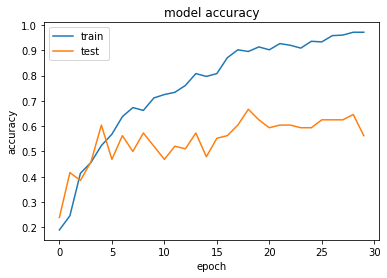

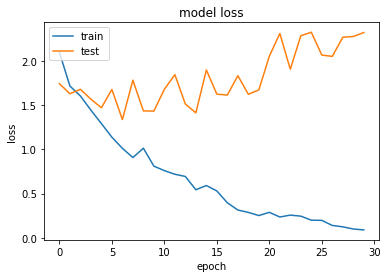

In [8]:
plt.plot(history.history['accuracy'])                   # accuracy plot for train,test data set
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])                       # loss plot for train,test
plt.plot(history.history['val_loss'])
plt.title('model loss' )
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### using pretrained model ResNet50 

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50        # importing pretrained model
from tensorflow.keras.models import Model

In [4]:
base_model = ResNet50(input_shape = (256, 256, 3),weights='imagenet',include_top=False) # initializing with pretrained weights

In [5]:
for layer in base_model.layers:                     # it is a pretrained model so do not need te train again so we set trainability = False
    layer.trainable = False

In [6]:
x = layers.Flatten()(base_model.output)

In [7]:
prediction = Dense(6,activation = 'softmax')(x)      # adding required output layer to the pretrained model

In [8]:
model = Model(inputs = base_model.input, outputs = prediction)      # initializing the model

In [9]:
model.compile(loss = 'CategoricalCrossentropy',optimizer = 'adam', metrics = ['accuracy'])  #  model compiling

In [10]:
# model fitting

history = model.fit(train_data, validation_data = validation_data, epochs = 40, steps_per_epoch = len(train_data),
                    validation_steps = len(validation_data))

Epoch 1/40
15/15 [==============================] - 49s 3s/step - loss: 17.9597 - accuracy: 0.1938 - val_loss: 17.0365 - val_accuracy: 0.1681
Epoch 2/40
15/15 [==============================] - 51s 3s/step - loss: 8.4925 - accuracy: 0.3049 - val_loss: 3.9658 - val_accuracy: 0.3529
Epoch 3/40
15/15 [==============================] - 51s 3s/step - loss: 3.4439 - accuracy: 0.3530 - val_loss: 2.8629 - val_accuracy: 0.3529
Epoch 4/40
15/15 [==============================] - 51s 3s/step - loss: 2.5890 - accuracy: 0.4331 - val_loss: 3.2218 - val_accuracy: 0.4454
Epoch 5/40
15/15 [==============================] - 49s 3s/step - loss: 2.1957 - accuracy: 0.4886 - val_loss: 1.9190 - val_accuracy: 0.4958
Epoch 6/40
15/15 [==============================] - 48s 3s/step - loss: 0.9677 - accuracy: 0.7029 - val_loss: 1.4914 - val_accuracy: 0.5294
Epoch 7/40
15/15 [==============================] - 50s 3s/step - loss: 0.9067 - accuracy: 0.6860 - val_loss: 1.3661 - val_accuracy: 0.5630
Epoch 8/40
15/15 [

In [11]:
score = model.evaluate(validation_data, verbose=0)  # calculating scores
  
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.3301583528518677
Test accuracy: 0.6386554837226868


### accuracy, loss plot

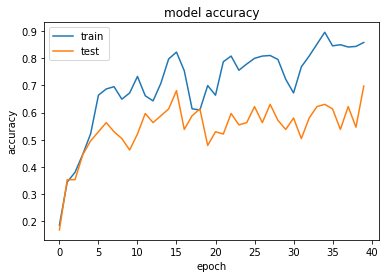

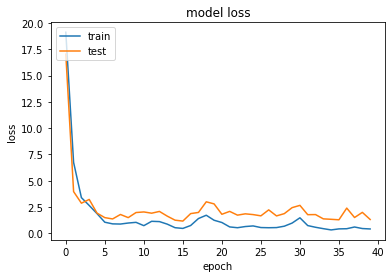

In [12]:
plt.plot(history.history['accuracy'])               # accuracy plot  
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])                    # loss plot 
plt.plot(history.history['val_loss'])
plt.title('model loss' )
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### testing image

In [13]:
import cv2

img = cv2.imread(r'E:\traindata\file explorer\f15.jpg', 1)
width = 256
height = 256
dim = (width, height)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
x_val = np.array(resized) / 255
x_val = x_val.reshape(-1, 256, 256, 3)

In [14]:
pred = model.predict(x_val)

In [15]:
print(pred)

[[6.9673904e-03 3.2495351e-09 1.0321991e-02 2.1190653e-03 5.3154922e-04
  9.8005998e-01]]


In [16]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________